In [98]:
import geemap 
import ee
from secret_vars import EARTHDATA_PASSWORD
import icepyx as ipx
import os
import numpy as np
import xarray as xr
import geopandas as gpd
import logging
import glob
from netCDF4 import Dataset as ncdataset

In [2]:
filelist = glob.glob('../data/ATLAS_test_subset/*/*.nc',recursive=True)
testfile = '../data/ATLAS_test_subset/177187253/processed_ATL12_20181014092931_02410101_003_01.nc'
# beam = 'gt2r'
testpath = '../data/ATLAS_test_subset/*/processed_ATL12_*.nc'

In [99]:
ncdataset(testfile)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    geospatial_lon_min: -179.99999095676924
    level: L3A
    identifier_product_doi: doi:10.5067/ATLAS/ATL12.003
    contributor_name: Thomas E Neumann (thomas.neumann@nasa.gov), Thorsten Markus (thorsten.markus@nasa.gov), Suneel Bhardwaj (suneel.bhardwaj@nasa.gov) David W Hancock III (david.w.hancock@nasa.gov)
    keywords: EARTH SCIENCE > OCEANS > SEA SURFACE TOPOGRAPHY > SEA SURFACE HEIGHT > NONE > NONE > NONE
    Processing Parameters: This file was gernerated by the ICESat-2 Service version 1.0 which performed the following operations on ATL12_20181014092931_02410101_003_01.h5
Extracted the datasets named:
/ds_surf_type/
/ds_xbin/
/ds_y_bincenters/
/ancillary_data/atlas_sdp_gps_epoch/
/ancillary_data/control/
/ancillary_data/data_end_utc/
/ancillary_data/data_start_utc/
/ancillary_data/end_cycle/
/ancillary_data/end_delta_time/
/ancillary_data/end_geoseg/
/ancillary_data/end_gpssow/
/ancillary_

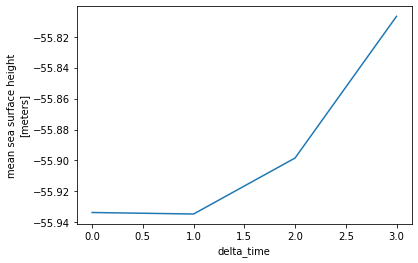

In [122]:
xr.open_dataset(testfile,group='gt1r/ssh_segments/heights/',).h.plot()

In [100]:
beamdict = {'gt1l': 0, 'gt1r': 1, 'gt2l': 2, 'gt2r': 3, 'gt3l': 4, 'gt3r': 5}

In [127]:
def open_single_beam(filepath,beam):
    
    dsheights = xr.open_dataset(filepath,group=f'{beam}/ssh_segments/heights')
    dscoords = xr.open_dataset(filepath,group=f'{beam}/ssh_segments')
    # we drop the histogram dimensions since they won't be used
    ds = dsheights.drop_dims(['ds_xbin','ds_y_bincenters']
        ).expand_dims({'lon':dscoords.longitude,'lat':dscoords.latitude}).drop_dims('delta_time')
    return ds

In [128]:
def allbeams(filepath):
    """iterator that yields all a dataset of all beams from a granule"""
    
    for beam in beamdict:
        try:
            yield open_single_beam(filepath,beam)
        # if the beam is not present, go to the next beam
        except OSError:
            continue
            
def allfiles(filelist):
    for file in filelist:
        fileds = xr.merge(allbeams(file))
        yield fileds
        

In [141]:
open_single_beam(testfile,'gt1l')

<xarray.Dataset>
Dimensions:  (lon: 1, lat: 1)
Coordinates:
  * lon      (lon) float64 89.05
  * lat      (lat) float64 21.42
Data variables:
    *empty*
Attributes:
    Description:  Contains parameters including and relating to the calculate...
    data_rate:    Data within this group are stored at the variable ocean pro...

In [130]:
xr.merge(allbeams(testfile))

<xarray.Dataset>
Dimensions:  (lon: 15, lat: 15)
Coordinates:
  * lon      (lon) float64 89.05 89.05 89.05 89.05 ... 89.08 89.11 89.12 89.12
  * lat      (lat) float64 21.4 21.4 21.41 21.41 ... 21.46 21.72 21.72 21.73
Data variables:
    *empty*
Attributes:
    Description:  Contains parameters including and relating to the calculate...
    data_rate:    Data within this group are stored at the variable ocean pro...

In [131]:
ds1,ds2,ds3,ds4,ds5 = allfiles(filelist=filelist[:5])

In [136]:
ds5

<xarray.Dataset>
Dimensions:  (lon: 20, lat: 20)
Coordinates:
  * lon      (lon) float64 89.51 89.51 89.53 89.53 ... 89.63 89.63 89.63 89.64
  * lat      (lat) float64 21.4 21.41 21.41 21.43 ... 21.85 21.87 21.97 22.03
Data variables:
    *empty*
Attributes:
    Description:  Contains parameters including and relating to the calculate...
    data_rate:    Data within this group are stored at the variable ocean pro...

In [137]:
combined_ds = xr.merge([ds1,ds2,ds3,ds4,ds5])

In [138]:
combined_ds

<xarray.Dataset>
Dimensions:  (lon: 84, lat: 84)
Coordinates:
  * lon      (lon) float64 89.03 89.05 89.05 89.05 ... 89.63 89.63 89.63 89.64
  * lat      (lat) float64 21.4 21.4 21.4 21.41 ... 21.85 21.87 21.97 22.03
Data variables:
    *empty*
Attributes:
    Description:  Contains parameters including and relating to the calculate...
    data_rate:    Data within this group are stored at the variable ocean pro...

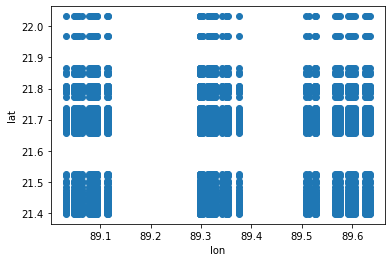

In [140]:
combined_ds.plot.scatter(x='lon',y='lat')

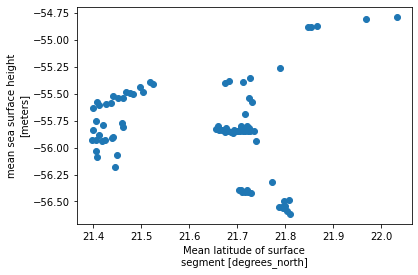

In [113]:
combined_ds.plot.scatter(x='lat',y='h')

In [ ]:
 dsheights.drop_dims(['ds_xbin','ds_y_bincenters'])

<xarray.Dataset>
Dimensions:      (delta_time: 4)
Dimensions without coordinates: delta_time
Data variables: (12/22)
    bin_ssbias   (delta_time) float32 ...
    h            (delta_time) float32 ...
    h_kurtosis   (delta_time) float32 ...
    h_skewness   (delta_time) float32 ...
    h_var        (delta_time) float32 ...
    length_seg   (delta_time) float64 ...
    ...           ...
    slope_seg    (delta_time) float64 ...
    swh          (delta_time) float32 ...
    ykurt        (delta_time) float32 ...
    ymean        (delta_time) float32 ...
    yskew        (delta_time) float32 ...
    yvar         (delta_time) float32 ...
Attributes:
    Description:  Contains parameters including and relating to the calculate...
    data_rate:    Data within this group are stored at the variable ocean pro...

In [16]:
feature = Map.draw_last_feature

response = feature.bounds().getInfo()
gee_bbox = response['geometry']['coordinates'][0]
gee_bbox = 


[[-79.329529, 22.178662],
 [-78.725281, 22.178662],
 [-78.725281, 22.432768],
 [-79.329529, 22.432768],
 [-79.329529, 22.178662]]

# Data loading
Testing out using the icepyx package to load icesat2 data granules. Right now for these toy examples I will just use a processed dataset as a test since it is a much lighter download.

In [6]:
datapath = '../data/ATLAS_test_subset/'
pattern = "processed_ATL{product:2}_{datetime:%Y%m%d%H%M%S}_{rgt:4}{cycle:2}{orbitsegment:2}_{version:3}_{revision:2}.h5"
pattern = "processed_ATL13_{datetime:%Y%m%d%H%M%S}_{rgt:4}{cycle:2}{orbitsegment:2}_{version:3}_{revision:2}.h5"

In [7]:
region_a = ipx.Query('ATL13',gee_bbox,['2019-02-22','2019-03-28'], start_time='00:00:00', end_time='23:59:59')
region_a.earthdata_login(uid='maelinds', email='max.lindsay95@gmail.com')
region_a.download_granules(path=datapath)

NameError: name 'gee_bbox' is not defined

In [12]:
reader = ipx.Read(data_source=datapath, product="ATL13", filename_pattern=pattern)
reader.vars.append(beam_list=['gt1l', 'gt3r'], var_list=["ht_water_surf", "bottom_lat", "bottom_lon"])
# reader.vars.wanted.pop('cycle_number')
reader.vars.wanted

You have 1 files matching the filename pattern to be read in.


{'sc_orient': ['orbit_info/sc_orient'],
 'atlas_sdp_gps_epoch': ['ancillary_data/atlas_sdp_gps_epoch'],
 'cycle_number': ['orbit_info/cycle_number'],
 'rgt': ['gt1l/rgt',
  'gt1r/rgt',
  'gt2l/rgt',
  'gt2r/rgt',
  'gt3l/rgt',
  'gt3r/rgt',
  'orbit_info/rgt'],
 'data_start_utc': ['ancillary_data/data_start_utc'],
 'data_end_utc': ['ancillary_data/data_end_utc'],
 'ht_water_surf': ['gt1l/ht_water_surf', 'gt3r/ht_water_surf'],
 'bottom_lat': ['gt1l/bottom_lat', 'gt3r/bottom_lat'],
 'bottom_lon': ['gt1l/bottom_lon', 'gt3r/bottom_lon']}

In [13]:
out = reader.load()

ValueError: conflicting sizes for dimension 'gran_idx': length 4 on 'cycle_number' and length 1 on {'gran_idx': 'gran_idx'}